# Incorporating Cometary Activity

The goal of this notebook is to demonstrate the apply cometary activity within `Sorcha`.

We will use the community tools part of the `Sorcha-addons`(https://github.com/dirac-institute/sorcha-addons) package

The idea is that the user can, in principle, implement their own method for cometary activity, and incorporate it in their simulation. The goal of `Sorcha-addons` is for both the development team, as well as for the community, to share their implementations of custom cometary activity models. 

In [1]:
import pandas as pd
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from sorcha.modules.PPCalculateApparentMagnitudeInFilter import PPCalculateApparentMagnitudeInFilter
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 14})

This notebook will not use a realistic set of observations (as in the `demo_ApparentMagnitudeValidation` notebook), but rather create a toy scenario with a simple to understand and interpret set of results. 

We will create a dataframe for observations in a similar structure as in the `demo_ApparentMagnitudeValidation` notebook:

In [2]:
observations_df = pd.DataFrame(
    {
        "fieldMJD_TAI": np.linspace(
            0, 100, 1001
        ),  # time of observation - note these values are bogus, we only care about the Delta t for this demo
        "H_filter": 17 * np.ones(1001),
        # starting at 30 au and coming inward to 5 au 
        "Range_LTC_km": 1.495978707e8 * np.flip(np.linspace(  0.2, 30, 1001)), # au
        "Obj_Sun_LTC_km": 1.495978707e8 * np.flip(np.linspace(1.2, 30, 1001)),  #  au
        "phase_deg": np.zeros(1001), 
        #keeping the same phase although this is unphysical so that we can look at just the effects of activity on the brightness of the object
        "optFilter": np.full(1001,'r',dtype=str), 
    }
)  

In [3]:
observations_df

,fieldMJD_TAI,H_filter,Range_LTC_km,Obj_Sun_LTC_km,phase_deg,optFilter
0,0.0,17.0,4.487936e+09,4.487936e+09,0.0,r
1,0.1,17.0,4.483478e+09,4.483628e+09,0.0,r
2,0.2,17.0,4.479020e+09,4.479319e+09,0.0,r
3,0.3,17.0,4.474562e+09,4.475011e+09,0.0,r
4,0.4,17.0,4.470104e+09,4.470702e+09,0.0,r
...,...,...,...,...,...,...
996,99.6,17.0,4.775164e+07,1.967511e+08,0.0,r
997,99.7,17.0,4.329362e+07,1.924427e+08,0.0,r
998,99.8,17.0,3.883561e+07,1.881343e+08,0.0,r
999,99.9,17.0,3.437759e+07,1.838259e+08,0.0,r


Now we calculate the magnitude of the nucleus assuming no phase curve model in PPCalculateApparentMagnitudeInFilter.

In [4]:
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), "none", "r", "Simple_mag")

In [5]:
observations_df

,fieldMJD_TAI,H_filter,Range_LTC_km,Obj_Sun_LTC_km,phase_deg,optFilter,Simple_mag
0,0.0,17.0,4.487936e+09,4.487936e+09,0.0,r,31.771213
1,0.1,17.0,4.483478e+09,4.483628e+09,0.0,r,31.766969
2,0.2,17.0,4.479020e+09,4.479319e+09,0.0,r,31.762721
3,0.3,17.0,4.474562e+09,4.475011e+09,0.0,r,31.758469
4,0.4,17.0,4.470104e+09,4.470702e+09,0.0,r,31.754213
...,...,...,...,...,...,...,...
996,99.6,17.0,4.775164e+07,1.967511e+08,0.0,r,15.115273
997,99.7,17.0,4.329362e+07,1.924427e+08,0.0,r,14.854373
998,99.8,17.0,3.883561e+07,1.881343e+08,0.0,r,14.569236
999,99.9,17.0,3.437759e+07,1.838259e+08,0.0,r,14.254156


Now we can plot the apparent magnitude of the inactive comet nucleus over time assuming no phase curve effects. Only the changing heliocentric and geocentric distances matter here. 

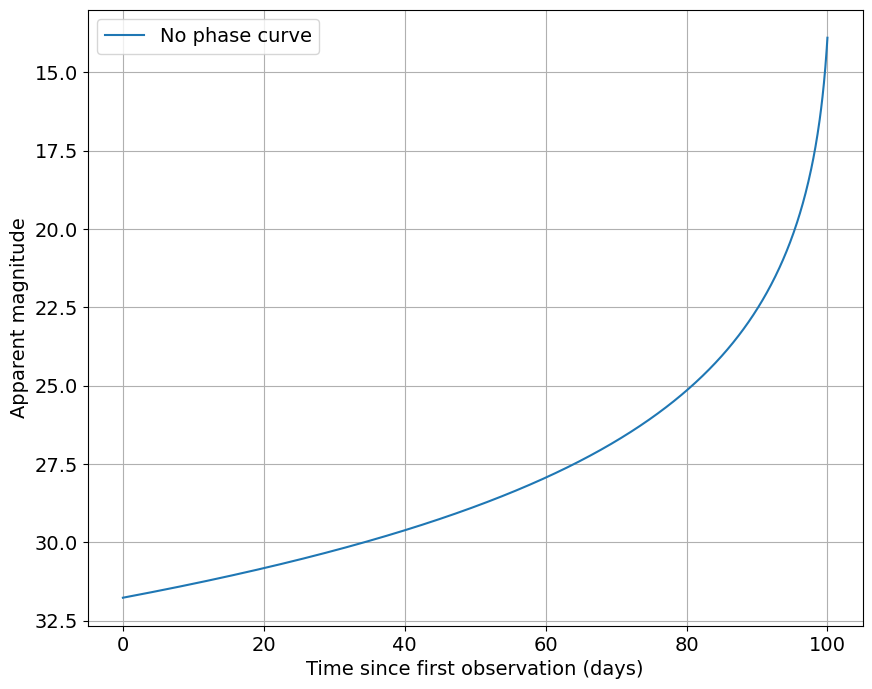

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(observations_df["fieldMJD_TAI"], observations_df["Simple_mag"], linestyle="-", label="No phase curve")

ax.legend()
ax.set_xlabel("Time since first observation (days)")
ax.set_ylabel("Apparent magnitude")
plt.gca().invert_yaxis()
plt.grid()
plt.show()

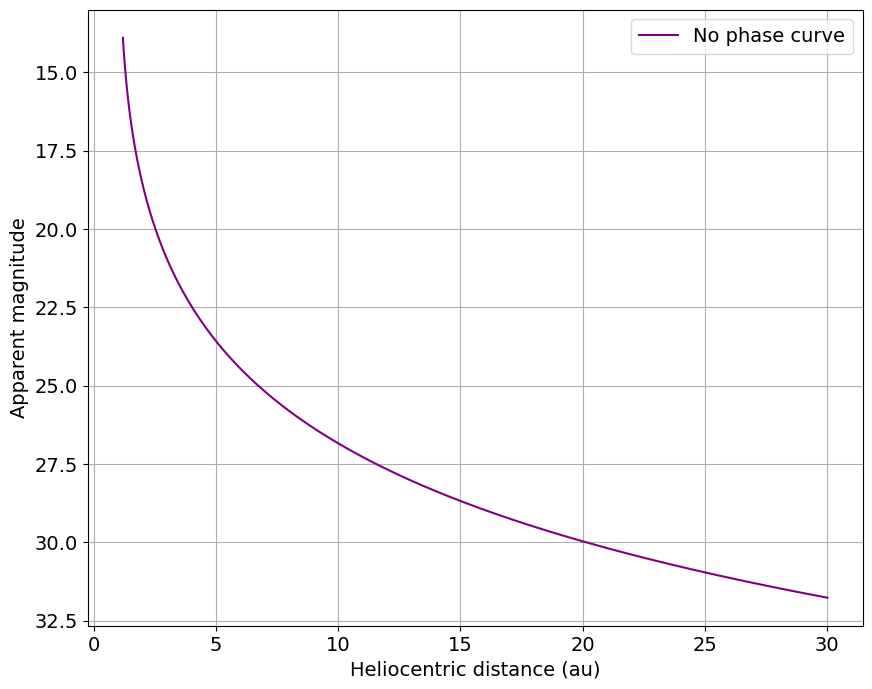

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(observations_df["Obj_Sun_LTC_km"]/1.495978707e8 , observations_df["Simple_mag"], linestyle="-", label="No phase curve", color='purple')

ax.legend()
ax.set_ylabel("Apparent magnitude")
ax.set_xlabel("Heliocentric distance (au)")
plt.gca().invert_yaxis()
plt.grid()
plt.show()

The effect of the cometary activity class is compute the apparent magnitude of the active object from an input apparent magnitude of the nucleus. The entire `observational_df` dataframe is exposed to the cometary activty class, so any dependencies can be added. 

Let's use the LSSTCometActivity class from `sorcha_addons`. We need the following columns in our dataframe:

* ``afrho1`` = V-band Afρ value of the comet at 1 au [cm]
* ``k`` = power-law slope that describes how the activity varies with heliocentric distance
     

Let's activate the LSSTCometActivity class 

In [8]:
from sorcha_addons.activity.lsst_comet.lsst_comet_activity import LSSTCometActivity
from sorcha.activity.activity_registration import update_activity_subclasses

update_activity_subclasses()

Let's calculate the apparent magnitude assuming 

In [9]:
observations_df["afrho1"] = 150
observations_df["k"] =-0.3


In [10]:
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), "none", "r",cometary_activity_choice="lsst_comet")

In [11]:
observations_df

,fieldMJD_TAI,H_filter,Range_LTC_km,Obj_Sun_LTC_km,phase_deg,optFilter,Simple_mag,afrho1,k,trailedSourceMagTrue,coma_magnitude
0,0.0,17.0,4.487936e+09,4.487936e+09,0.0,r,31.771213,150,-0.3,27.523035,27.544954
1,0.1,17.0,4.483478e+09,4.483628e+09,0.0,r,31.766969,150,-0.3,27.519542,27.541477
2,0.2,17.0,4.479020e+09,4.479319e+09,0.0,r,31.762721,150,-0.3,27.516046,27.537996
3,0.3,17.0,4.474562e+09,4.475011e+09,0.0,r,31.758469,150,-0.3,27.512546,27.534512
4,0.4,17.0,4.470104e+09,4.470702e+09,0.0,r,31.754213,150,-0.3,27.509043,27.531024
...,...,...,...,...,...,...,...,...,...,...,...
996,99.6,17.0,4.775164e+07,1.967511e+08,0.0,r,15.115273,150,-0.3,14.195410,14.803064
997,99.7,17.0,4.329362e+07,1.924427e+08,0.0,r,14.854373,150,-0.3,13.990077,14.641362
998,99.8,17.0,3.883561e+07,1.881343e+08,0.0,r,14.569236,150,-0.3,13.764254,14.466835
999,99.9,17.0,3.437759e+07,1.838259e+08,0.0,r,14.254156,150,-0.3,13.512743,14.276596


Let's plot by time

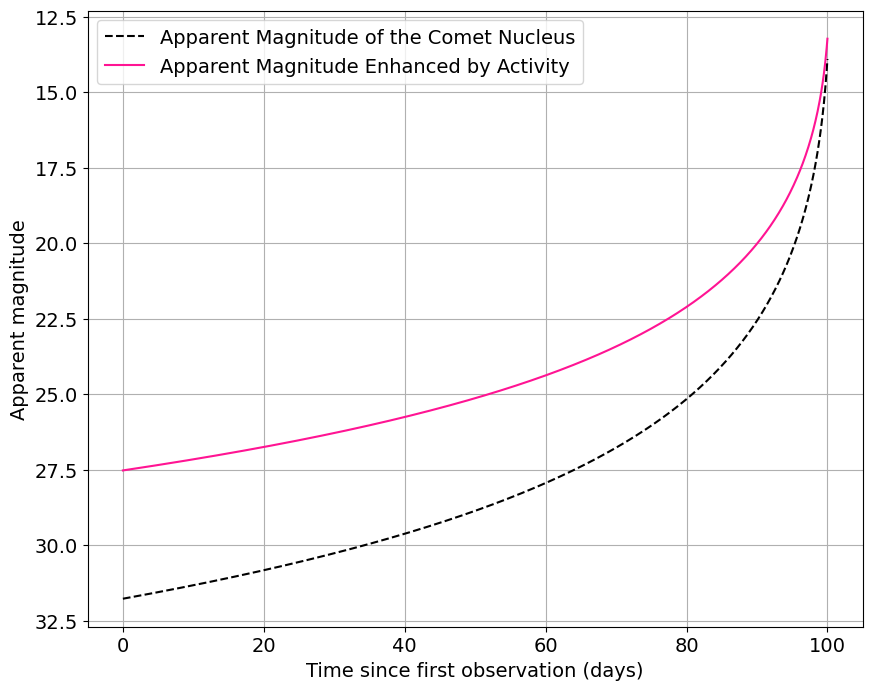

In [12]:

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["Simple_mag"],
    linestyle="--",
    label="Apparent Magnitude of the Comet Nucleus",
    color="black",
)
ax.plot(
    observations_df["fieldMJD_TAI"], observations_df["trailedSourceMagTrue"], linestyle="-", label="Apparent Magnitude Enhanced by Activity", color="deeppink"
)

plt.legend()
ax.set_xlabel("Time since first observation (days)")
ax.set_ylabel("Apparent magnitude")
plt.gca().invert_yaxis()
plt.grid()
plt.show()

Let's plot by time and look closer to perihleion

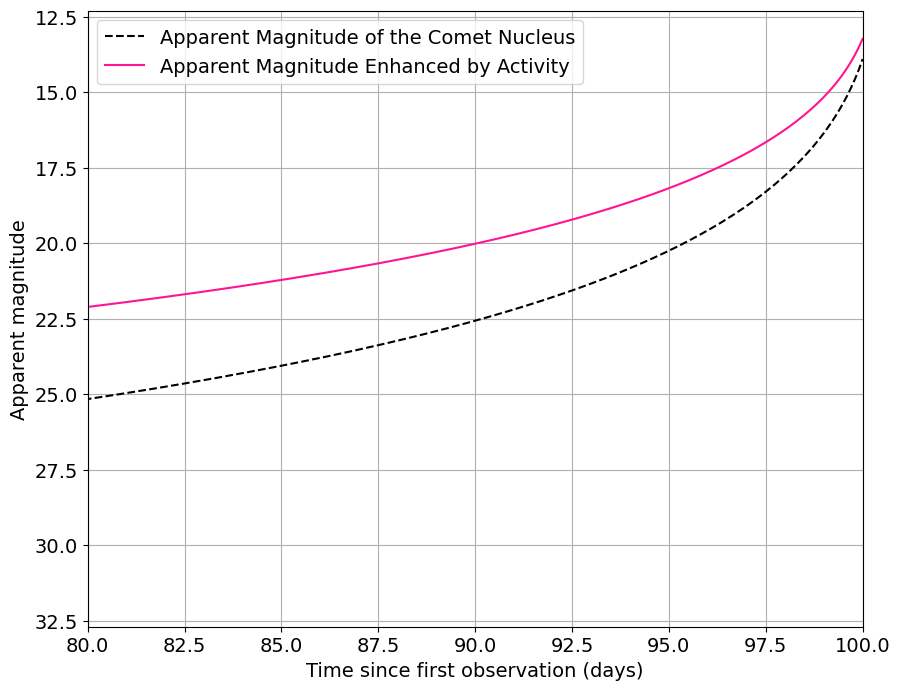

In [13]:

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["Simple_mag"],
    linestyle="--",
    label="Apparent Magnitude of the Comet Nucleus",
    color="black",
)
ax.plot(
    observations_df["fieldMJD_TAI"], observations_df["trailedSourceMagTrue"], linestyle="-", label="Apparent Magnitude Enhanced by Activity", color="deeppink"
)

plt.legend()
ax.set_xlabel("Time since first observation (days)")
ax.set_ylabel("Apparent magnitude")
plt.gca().invert_yaxis()
plt.xlim(80,100)
plt.grid()
plt.show()


Let's plot by heliocentric distance

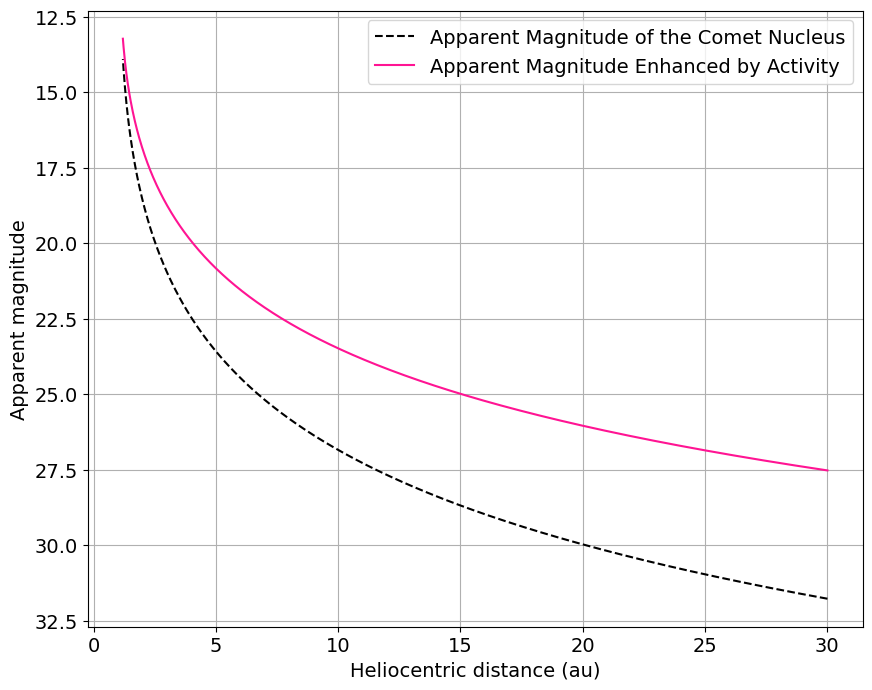

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(
    observations_df["Obj_Sun_LTC_km"]/1.495978707e8,
    observations_df["Simple_mag"],
    linestyle="--",
    label="Apparent Magnitude of the Comet Nucleus",
    color="black",
)
ax.plot(
    observations_df["Obj_Sun_LTC_km"]/1.495978707e8, observations_df["trailedSourceMagTrue"], linestyle="-", label="Apparent Magnitude Enhanced by Activity", color="deeppink"
)

plt.legend()
ax.set_xlabel("Heliocentric distance (au)")
ax.set_ylabel("Apparent magnitude")
plt.gca().invert_yaxis()
plt.grid()
plt.show()


Let's plot by heliocentric distance and zoom in close to perihelion

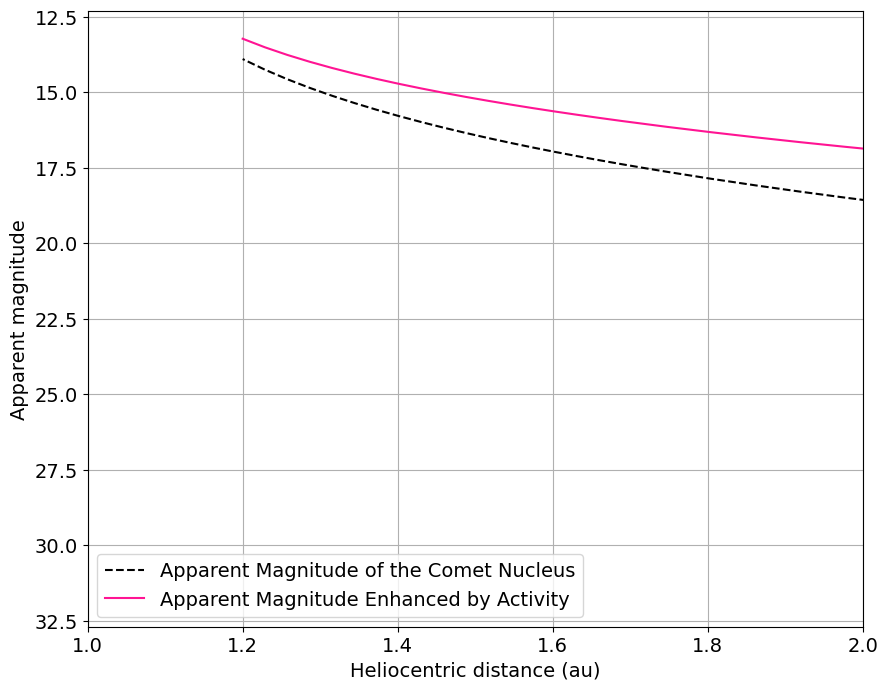

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(
    observations_df["Obj_Sun_LTC_km"]/1.495978707e8,
    observations_df["Simple_mag"],
    linestyle="--",
    label="Apparent Magnitude of the Comet Nucleus",
    color="black",
)
ax.plot(
    observations_df["Obj_Sun_LTC_km"]/1.495978707e8, observations_df["trailedSourceMagTrue"], linestyle="-", label="Apparent Magnitude Enhanced by Activity", color="deeppink"
)

plt.legend()
ax.set_xlabel("Heliocentric distance (au)")
ax.set_ylabel("Apparent magnitude")
plt.gca().invert_yaxis()
plt.xlim(1.0,2)
plt.grid()
plt.show()

At larger heliocentric distances the nucelus does not contribute much. The coma is the main contribution to the apparent magnitude at those distances, and the comet is observed to be much brighter than an inactive body at the same heliocentric distance. Closer to the Sun, the nucleus contribution to the apparent magntiude is more significant.